cuda


Training:  10%|█         | 51/500 [00:10<01:32,  4.83it/s]

[Episode 50] Max Q-value diff at t=0: 1076.663696


Training:  20%|██        | 101/500 [00:20<01:23,  4.81it/s]

[Episode 100] Max Q-value diff at t=0: 188.782654


Training:  30%|███       | 151/500 [00:30<01:13,  4.76it/s]

[Episode 150] Max Q-value diff at t=0: 137.687683


Training:  40%|████      | 201/500 [00:41<01:03,  4.73it/s]

[Episode 200] Max Q-value diff at t=0: 80.915527


Training:  50%|█████     | 251/500 [00:51<00:52,  4.77it/s]

[Episode 250] Max Q-value diff at t=0: 128.887329


Training:  60%|██████    | 301/500 [01:01<00:41,  4.81it/s]

[Episode 300] Max Q-value diff at t=0: 1184.416138


Training:  70%|███████   | 351/500 [01:12<00:31,  4.70it/s]

[Episode 350] Max Q-value diff at t=0: 579.902344


Training:  80%|████████  | 401/500 [01:22<00:21,  4.70it/s]

[Episode 400] Max Q-value diff at t=0: 969.400757


Training:  90%|█████████ | 451/500 [01:33<00:10,  4.55it/s]

[Episode 450] Max Q-value diff at t=0: 658.536133


Training: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]

Training complete


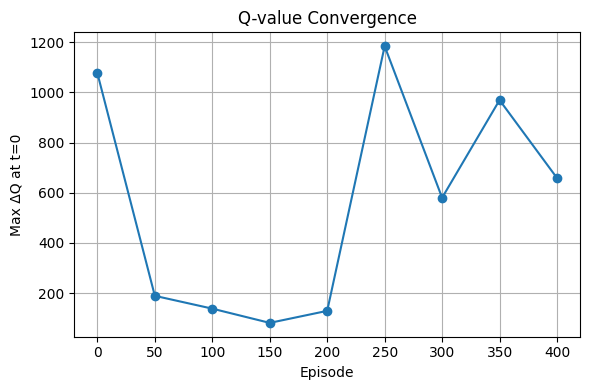


Time | Inv | Demand | Action
------------------------------------
   0 |    0 |      6 |      9
   1 |    3 |      0 |      2
   2 |    5 |      2 |      2
   3 |    5 |      4 |      2
   4 |    3 |     10 |      2
   5 |   -5 |      4 |      9
   6 |    0 |      0 |      2
   7 |    2 |      4 |      2
   8 |    0 |      7 |      2
   9 |   -5 |      0 |      5
  10 |    0 |     10 |      2
  11 |   -8 |      7 |      9
  12 |   -6 |      4 |      9
  13 |   -1 |      6 |      2
  14 |   -5 |      1 |      2
  15 |   -4 |      8 |      2
  16 |  -10 |      8 |      9
  17 |   -9 |     10 |      9
  18 |  -10 |      3 |      9
  19 |   -4 |      6 |      2
  20 |   -8 |      8 |      9
  21 |   -7 |      1 |      9
  22 |    1 |      3 |      1
  23 |   -1 |     10 |      1
  24 |  -10 |      7 |      9
  25 |   -8 |      8 |      9
  26 |   -7 |      4 |      9
  27 |   -2 |      9 |      1
  28 |  -10 |      6 |      9
  29 |   -7 |      6 |      9
  30 |   -4 |      8 |      1
  3

/tmp/ipykernel_31/1767121743.py:243: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(f"frames/{t:03d}.png"))


GIF saved as vf_evolution_ar_30.gif


In [2]:
import os, random, imageio, shutil
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------
# 1) ENVIRONMENT
# -----------------------

class InventoryEnv:
    def __init__(self, min_inv=-50, max_inv=50, T=50):
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.T       = T
        self.ep_num  = 0  # Add this line
        self.reset()

    def set_episode(self, ep_num):
        self.ep_num = ep_num

    def reset(self):
        self.s = random.randint(self.min_inv, self.max_inv)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, a):
        # Switch demand distribution based on episode number
        if self.ep_num < episodes // 2:
            w = random.randint(0, 10)
        else:
            w = random.randint(10, 15)

        s2 = self.s + a - w
        s2 = max(self.min_inv, min(self.max_inv, s2))

        p, a_cost, b_cost = 1, 1, 2
        order_cost = p * a
        inv_cost   = a_cost * s2 if s2 >= 0 else b_cost * (-s2)
        cost       = order_cost + inv_cost
        r = cost

        self.t += 1
        done = (self.t >= self.T)
        self.s = s2
        obs = np.array([self.s, self.t if not done else 0], dtype=np.float32)
        return obs, r, done


# -----------------------
# 2) Q-NETWORK
# -----------------------

class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------
# 3) REPLAY BUFFER
# -----------------------
class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self, *args):    self.buf.append(tuple(args))
    def sample(self, k):
        batch = random.sample(self.buf, k)
        return zip(*batch)
    def __len__(self): return len(self.buf)

# -----------------------
# 4) HYPERPARAMETERS
# -----------------------
num_actions      = 10
state_dim        = 2
T                = 100
min_inv, max_inv = -50, 50
gamma            = 1.0
eps_start        = 0.9
eps_end          = 0.05
eps_decay        = 5000
buffer_cap       = 50_000
batch_size       = 32
lr               = 1e-3
target_update    = 10
episodes         = 500

# -----------------------
# 5) SETUP
# -----------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env        = InventoryEnv(min_inv, max_inv, T)
policy_net = DQN(state_dim, num_actions).to(device)
target_net = DQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt        = optim.Adam(policy_net.parameters(), lr=lr)
buf        = ReplayBuffer(buffer_cap)

step_count = 0
eps        = eps_start

# For Q-value convergence check
q_convergence = []
prev_q_snapshot = None
check_convergence_interval = 50

# -----------------------
# 6) TRAIN
# -----------------------
for ep in trange(episodes, desc="Training"):
    env.set_episode(ep)
    obs = env.reset()
    done= False
    while not done:
        if random.random() < eps:
            a = random.randrange(num_actions)
        else:
            st = torch.FloatTensor(obs).unsqueeze(0).to(device)
            qv = policy_net(st)
            a  = int(qv.argmin(dim=1).item())

        obs2, r, done = env.step(a)
        buf.push(obs, a, r, obs2, done)
        obs = obs2

        if len(buf) >= batch_size:
            s_batch, a_batch, r_batch, s2_batch, d_batch = buf.sample(batch_size)
            s_v  = torch.FloatTensor(s_batch).to(device)
            a_v  = torch.LongTensor(a_batch).to(device)
            r_v  = torch.FloatTensor(r_batch).to(device)
            s2_v = torch.FloatTensor(s2_batch).to(device)
            d_v  = torch.FloatTensor(d_batch).to(device)

            q_vals = policy_net(s_v).gather(1, a_v.unsqueeze(-1)).squeeze(-1)

            with torch.no_grad():
                best_actions = policy_net(s2_v).argmin(dim=1)
                q2_selected = target_net(s2_v).gather(1, best_actions.unsqueeze(-1)).squeeze(-1)
                target = r_v + gamma * q2_selected * (1 - d_v)

            loss = nn.MSELoss()(q_vals, target)
            opt.zero_grad(); loss.backward(); opt.step()

            step_count += 1
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

    eps = eps

    if ep % check_convergence_interval == 0:
        with torch.no_grad():
            q_snapshot = []
            for s in range(min_inv, max_inv+1):
                st = torch.FloatTensor([[s, 0]]).to(device)
                qs = policy_net(st).cpu().numpy()[0]
                q_snapshot.append(qs)
            q_snapshot = np.array(q_snapshot)

        if prev_q_snapshot is not None:
            diff = np.abs(prev_q_snapshot - q_snapshot)
            max_diff = np.max(diff)
            q_convergence.append(max_diff)
            print(f"[Episode {ep}] Max Q-value diff at t=0: {max_diff:.6f}")
        prev_q_snapshot = q_snapshot

print("Training complete")

# -----------------------
# Plot Q-value convergence
# -----------------------
if q_convergence:
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(len(q_convergence)) * check_convergence_interval, q_convergence, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Max ΔQ at t=0")
    plt.title("Q-value Convergence")
    plt.grid()
    plt.tight_layout()
    plt.show()

# -----------------------
# Extract Q-table & V(s,t) with fix for t=T-1
# -----------------------
policy_net.eval()
num_states = max_inv - min_inv + 1
Q_tab  = np.zeros((T, num_states, num_actions), dtype=np.float32)
V_tab  = np.zeros((T, num_states), dtype=np.float32)
pi_tab = np.zeros((T, num_states), dtype=int)

with torch.no_grad():
    for t in range(T):
        for i, s in enumerate(range(min_inv, max_inv+1)):
            if t == T - 1:
                Q_tab[t, i] = np.zeros(num_actions)
                V_tab[t, i] = 0
                pi_tab[t, i] = 0
            else:
                st = torch.FloatTensor([[s, t]]).to(device)
                qs = policy_net(st).cpu().numpy()[0]
                Q_tab[t, i] = qs
                a_opt = int(np.argmin(qs))
                pi_tab[t, i] = a_opt
                V_tab[t, i] = qs[a_opt]

# -----------------------
# 9) ROLLOUT DEMO
# -----------------------
print("\nTime | Inv | Demand | Action")
print("------------------------------------")
s = 0
for t in range(T):
    w = random.randint(0,10)
    a = pi_tab[t, s-min_inv]
    print(f"{t:4d} | {s:4d} | {w:6d} | {a:6d}")
    s = max(min_inv, min(max_inv, s + a - w))

# -----------------------
# 11) GIF of V(s) over t
# -----------------------
states = np.arange(min_inv, max_inv+1)
os.makedirs("frames", exist_ok=True)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}"); plt.tight_layout()
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn); plt.close()

with imageio.get_writer("vf_evolution_ar_30.gif", mode="I", duration=0.1) as w:
    for t in range(T):
        w.append_data(imageio.imread(f"frames/{t:03d}.png"))

shutil.rmtree("frames")
print("GIF saved as vf_evolution_ar_30.gif")


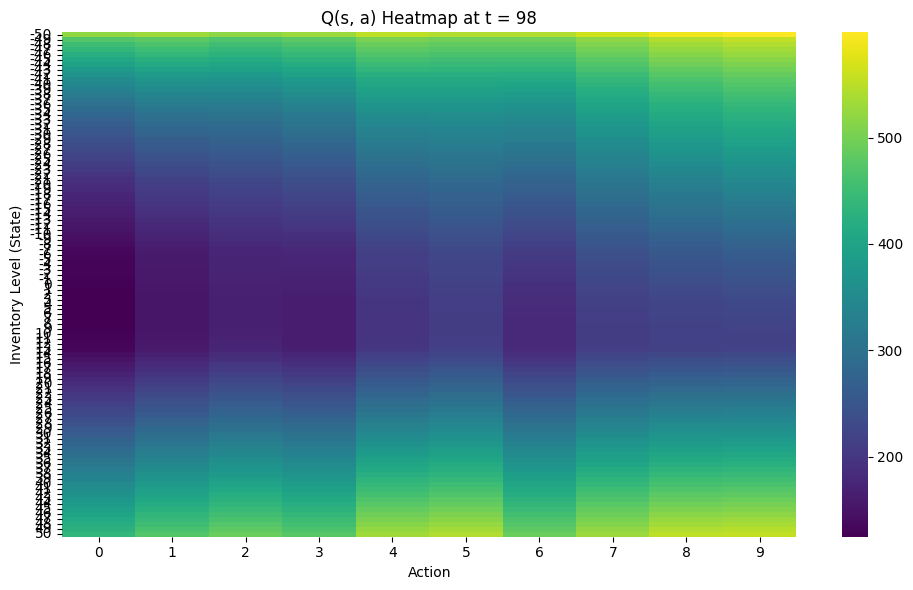

In [7]:
# -----------------------
# 10) Q(s, a) Heatmap at t = 0
# -----------------------
import seaborn as sns

# Create a matrix of Q-values at t=0 for all states and actions
q_matrix = Q_tab[98]  # Shape: (num_states, num_actions)

plt.figure(figsize=(10, 6))
sns.heatmap(q_matrix, cmap="viridis", xticklabels=True, yticklabels=np.arange(min_inv, max_inv+1))
plt.xlabel("Action")
plt.ylabel("Inventory Level (State)")
plt.title("Q(s, a) Heatmap at t = 98")
plt.tight_layout()
plt.show()


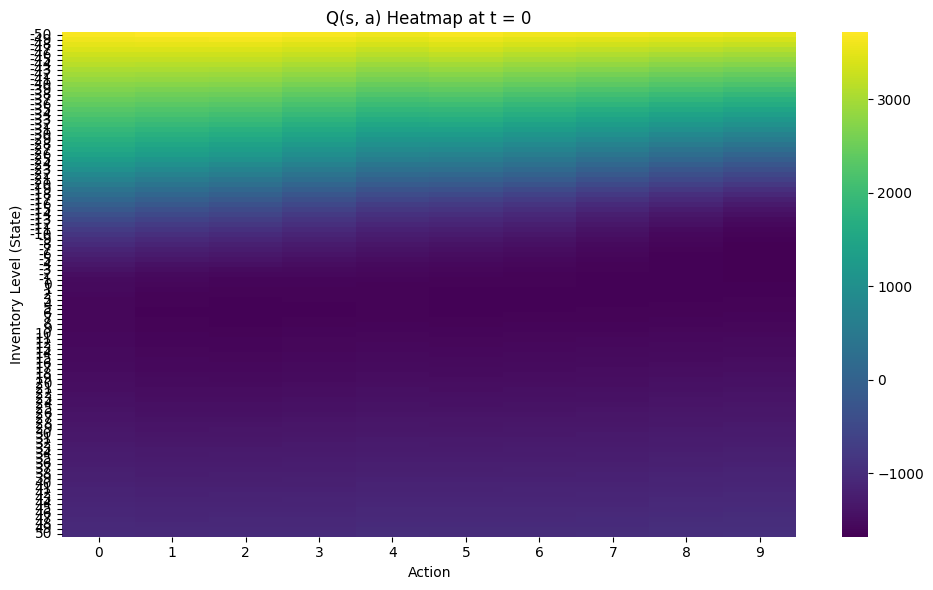

In [9]:
# -----------------------
# 10) Q(s, a) Heatmap at t = 0
# -----------------------
import seaborn as sns
T=0
# Create a matrix of Q-values at t=0 for all states and actions
q_matrix = Q_tab[T]  # Shape: (num_states, num_actions)

plt.figure(figsize=(10, 6))
sns.heatmap(q_matrix, cmap="viridis", xticklabels=True, yticklabels=np.arange(min_inv, max_inv+1))
plt.xlabel("Action")
plt.ylabel("Inventory Level (State)")
plt.title(f"Q(s, a) Heatmap at t = {T}")
plt.tight_layout()
plt.show()


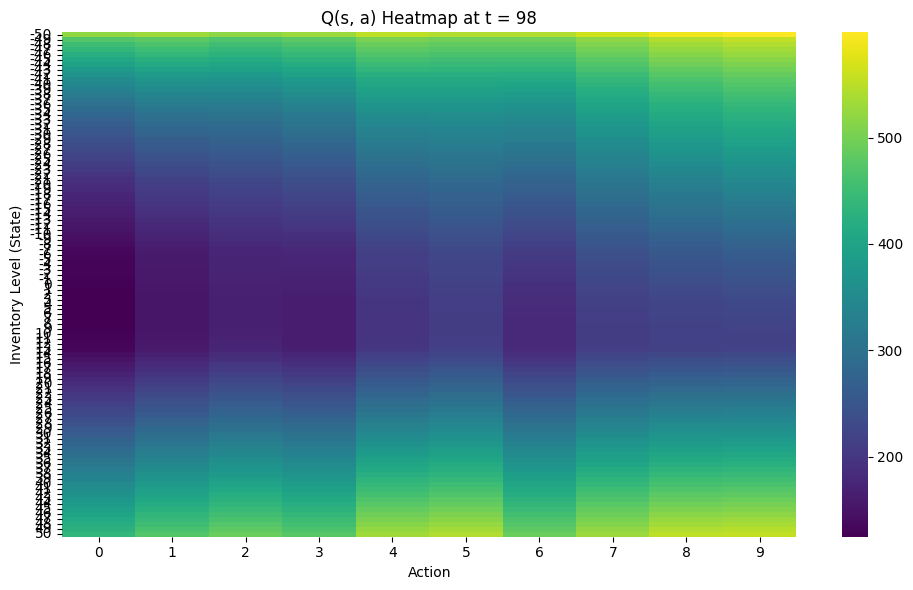

In [11]:
# -----------------------
# 10) Q(s, a) Heatmap at t = 0
# -----------------------
import seaborn as sns
T=98
# Create a matrix of Q-values at t=0 for all states and actions
q_matrix = Q_tab[T]  # Shape: (num_states, num_actions)

plt.figure(figsize=(10, 6))
sns.heatmap(q_matrix, cmap="viridis", xticklabels=True, yticklabels=np.arange(min_inv, max_inv+1))
plt.xlabel("Action")
plt.ylabel("Inventory Level (State)")
plt.title(f"Q(s, a) Heatmap at t = {T}")
plt.tight_layout()
plt.show()


## Observing promising results, as at t=0, low actions drive the Q-values higher, something we dont want. And at last time step, higher actions drive the Q-Values higher.

cuda


Training:  10%|█         | 51/500 [00:10<01:40,  4.46it/s]

[Episode 50] Max Q-value diff at t=0: 3810.040771


Training:  20%|██        | 101/500 [00:21<01:28,  4.53it/s]

[Episode 100] Max Q-value diff at t=0: 1113.410400


Training:  30%|███       | 151/500 [00:32<01:18,  4.45it/s]

[Episode 150] Max Q-value diff at t=0: 851519.000000


Training:  40%|████      | 201/500 [00:42<01:06,  4.51it/s]

[Episode 200] Max Q-value diff at t=0: 10338517.000000


Training:  50%|█████     | 251/500 [00:53<00:53,  4.62it/s]

[Episode 250] Max Q-value diff at t=0: 23948088.000000


Training:  60%|██████    | 301/500 [01:04<00:43,  4.54it/s]

[Episode 300] Max Q-value diff at t=0: 43398680.000000


Training:  70%|███████   | 351/500 [01:15<00:33,  4.46it/s]

[Episode 350] Max Q-value diff at t=0: 69612704.000000


Training:  80%|████████  | 401/500 [01:26<00:23,  4.28it/s]

[Episode 400] Max Q-value diff at t=0: 101893392.000000


Training:  90%|█████████ | 451/500 [01:37<00:10,  4.54it/s]

[Episode 450] Max Q-value diff at t=0: 144971264.000000


Training: 100%|██████████| 500/500 [01:47<00:00,  4.64it/s]

Training complete


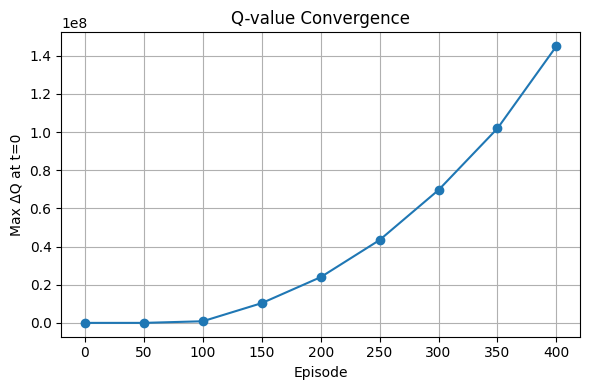


Time | Inv | Demand | Action
------------------------------------
   0 |    0 |      9 |      9
   1 |    0 |      6 |      9
   2 |    3 |      0 |      9
   3 |   12 |      0 |      9
   4 |   21 |      2 |      9
   5 |   28 |      3 |      9
   6 |   34 |      9 |      9
   7 |   34 |      6 |      9
   8 |   37 |      8 |      9
   9 |   38 |      7 |      9
  10 |   40 |      8 |      9
  11 |   41 |      0 |      9
  12 |   50 |      2 |      9
  13 |   50 |      3 |      9
  14 |   50 |      4 |      9
  15 |   50 |      5 |      9
  16 |   50 |      3 |      9
  17 |   50 |      3 |      9
  18 |   50 |     10 |      9
  19 |   49 |      8 |      9
  20 |   50 |      6 |      9
  21 |   50 |      7 |      9
  22 |   50 |      6 |      9
  23 |   50 |      1 |      9
  24 |   50 |      6 |      9
  25 |   50 |      3 |      9
  26 |   50 |      1 |      9
  27 |   50 |     10 |      9
  28 |   49 |      1 |      9
  29 |   50 |      3 |      9
  30 |   50 |      6 |      9
  3

/tmp/ipykernel_31/727285998.py:234: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(f"frames/{t:03d}.png"))


GIF saved as vf_evolution_ar_31.gif


In [12]:
import os, random, imageio, shutil
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------
# 1) ENVIRONMENT
# -----------------------

class InventoryEnv:
    def __init__(self, min_inv=-50, max_inv=50, T=50):
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.T       = T
        self.reset()

    def reset(self):
        self.s = random.randint(self.min_inv, self.max_inv)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, a):
        # Time-varying demand: W_t ~ Poisson(λ = 5 + 0.1 * t)
        lambda_t = 5 + 0.1 * self.t
        w = np.random.poisson(lambda_t)
        s2 = self.s + a - w
        s2 = max(self.min_inv, min(self.max_inv, s2))

        p, a_cost, b_cost = 1, 1, 2
        order_cost = p * a
        inv_cost   = a_cost * s2 if s2 >= 0 else b_cost * (-s2)
        cost       = order_cost + inv_cost
        r = cost

        self.t += 1
        done = (self.t >= self.T)
        self.s = s2
        obs = np.array([self.s, self.t if not done else 0], dtype=np.float32)
        return obs, r, done

# -----------------------
# 2) Q-NETWORK
# -----------------------

class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------
# 3) REPLAY BUFFER
# -----------------------
class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self, *args):    self.buf.append(tuple(args))
    def sample(self, k):
        batch = random.sample(self.buf, k)
        return zip(*batch)
    def __len__(self): return len(self.buf)

# -----------------------
# 4) HYPERPARAMETERS
# -----------------------
num_actions      = 10
state_dim        = 2
T                = 100
min_inv, max_inv = -50, 50
gamma            = 1.0
eps_start        = 0.9
eps_end          = 0.05
eps_decay        = 5000
buffer_cap       = 50_000
batch_size       = 32
lr               = 1e-3
target_update    = 10
episodes         = 500

# -----------------------
# 5) SETUP
# -----------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env        = InventoryEnv(min_inv, max_inv, T)
policy_net = DQN(state_dim, num_actions).to(device)
target_net = DQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt        = optim.Adam(policy_net.parameters(), lr=lr)
buf        = ReplayBuffer(buffer_cap)

step_count = 0
eps        = eps_start

# For Q-value convergence check
q_convergence = []
prev_q_snapshot = None
check_convergence_interval = 50

# -----------------------
# 6) TRAIN
# -----------------------
for ep in trange(episodes, desc="Training"):
    obs = env.reset()
    done= False
    while not done:
        if random.random() < eps:
            a = random.randrange(num_actions)
        else:
            st = torch.FloatTensor(obs).unsqueeze(0).to(device)
            qv = policy_net(st)
            a  = int(qv.argmin(dim=1).item())

        obs2, r, done = env.step(a)
        buf.push(obs, a, r, obs2, done)
        obs = obs2

        if len(buf) >= batch_size:
            s_batch, a_batch, r_batch, s2_batch, d_batch = buf.sample(batch_size)
            s_v  = torch.FloatTensor(s_batch).to(device)
            a_v  = torch.LongTensor(a_batch).to(device)
            r_v  = torch.FloatTensor(r_batch).to(device)
            s2_v = torch.FloatTensor(s2_batch).to(device)
            d_v  = torch.FloatTensor(d_batch).to(device)

            q_vals = policy_net(s_v).gather(1, a_v.unsqueeze(-1)).squeeze(-1)

            with torch.no_grad():
                best_actions = policy_net(s2_v).argmin(dim=1)
                q2_selected = target_net(s2_v).gather(1, best_actions.unsqueeze(-1)).squeeze(-1)
                target = r_v + gamma * q2_selected * (1 - d_v)

            loss = nn.MSELoss()(q_vals, target)
            opt.zero_grad(); loss.backward(); opt.step()

            step_count += 1
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

    eps = eps

    if ep % check_convergence_interval == 0:
        with torch.no_grad():
            q_snapshot = []
            for s in range(min_inv, max_inv+1):
                st = torch.FloatTensor([[s, 0]]).to(device)
                qs = policy_net(st).cpu().numpy()[0]
                q_snapshot.append(qs)
            q_snapshot = np.array(q_snapshot)

        if prev_q_snapshot is not None:
            diff = np.abs(prev_q_snapshot - q_snapshot)
            max_diff = np.max(diff)
            q_convergence.append(max_diff)
            print(f"[Episode {ep}] Max Q-value diff at t=0: {max_diff:.6f}")
        prev_q_snapshot = q_snapshot

print("Training complete")

# -----------------------
# Plot Q-value convergence
# -----------------------
if q_convergence:
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(len(q_convergence)) * check_convergence_interval, q_convergence, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Max ΔQ at t=0")
    plt.title("Q-value Convergence")
    plt.grid()
    plt.tight_layout()
    plt.show()

# -----------------------
# Extract Q-table & V(s,t) with fix for t=T-1
# -----------------------
policy_net.eval()
num_states = max_inv - min_inv + 1
Q_tab  = np.zeros((T, num_states, num_actions), dtype=np.float32)
V_tab  = np.zeros((T, num_states), dtype=np.float32)
pi_tab = np.zeros((T, num_states), dtype=int)

with torch.no_grad():
    for t in range(T):
        for i, s in enumerate(range(min_inv, max_inv+1)):
            if t == T - 1:
                Q_tab[t, i] = np.zeros(num_actions)
                V_tab[t, i] = 0
                pi_tab[t, i] = 0
            else:
                st = torch.FloatTensor([[s, t]]).to(device)
                qs = policy_net(st).cpu().numpy()[0]
                Q_tab[t, i] = qs
                a_opt = int(np.argmin(qs))
                pi_tab[t, i] = a_opt
                V_tab[t, i] = qs[a_opt]

# -----------------------
# 9) ROLLOUT DEMO
# -----------------------
print("\nTime | Inv | Demand | Action")
print("------------------------------------")
s = 0
for t in range(T):
    w = random.randint(0,10)
    a = pi_tab[t, s-min_inv]
    print(f"{t:4d} | {s:4d} | {w:6d} | {a:6d}")
    s = max(min_inv, min(max_inv, s + a - w))

# -----------------------
# 11) GIF of V(s) over t
# -----------------------
states = np.arange(min_inv, max_inv+1)
os.makedirs("frames", exist_ok=True)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}"); plt.tight_layout()
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn); plt.close()

with imageio.get_writer("vf_evolution_ar_31.gif", mode="I", duration=0.1) as w:
    for t in range(T):
        w.append_data(imageio.imread(f"frames/{t:03d}.png"))

shutil.rmtree("frames")
print("GIF saved as vf_evolution_ar_31.gif")
